# Why are they leaving us?

By Ednalyn C. De Dios & Michael P. Moran

## Project Planning

### Goals
1. Explain what is driving customers to churn.

### Questions Presented & Answers
1. Could the month in which they signed up influence churn? i.e. if a cohort is identified by tenure, is there a cohort or cohorts who have a higher rate of churn than other cohorts? (Plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers))
1. Are there features that indicate a higher propensity to churn? like type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?
1. Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?
1. If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

### Data Dictionary & Domain Knowledge

### gender

| Description | gender
| ------------- |-------------
| Female      | 0
| Male      | 1

### phone_id

| Phone Service | phone_id
| ------------- |-------------
| No phone      | 0
| One Line      | 1
| Two+ lines    | 2

### household_type_id

| Partner & Dependents      | household_type_id
| -------------             |-------------
| No partner, no dependents      | 0
| Partner, no dependents      | 1
| No partner, dependents    | 2
| Partner, dependents | 3

### streaming_services

| Streaming TV & Streaming Movies      | streaming_services
| -------------             |-------------
| No internet service      | 0
| No streaming tv, no streaming movies      | 1
| Has streaming tv, no streaming movies    | 2
| No streaming tv, has streaming movies | 3
| Has streaming tv, has streaming movies | 4

### online_security_backup

| Online Security & Online Backup      | online_security_backup
| -------------             |-------------
| No internet service      | 0
| No security, no backup | 1
| Has security, no backup | 2
| No security, has backup | 3
| Has security, has backup | 4

### device_protection
| Device Protection | Value
| ------ |-----
| No internet service | 1
| No | 0
| Yes | 2

### tech_support
| Tech Support | Value
| ------ |-----
| No internet service | 1
| No | 0
| Yes | 2

### paperless_billing
| Paperless Billing | Value
| ------ |-----
| No | 0
| Yes | 1

### internet_service_type
| internet_service_type_id | internet_service_type |
| ------ |-----|
|                        0 | None                  |
|                        1 | DSL                   |
|                        2 | Fiber optic           |


### payment types
| payment_type_id | payment_type              |
| ------ |-----
|               1 | Electronic check          |
|               2 | Mailed check              |
|               3 | Bank transfer (automatic) |
|               4 | Credit card (automatic)   |


### contract_type_id
| contract_type_id | contract_type  |
| ------ |-----
|                1 | Month-to-month |
|                2 | One year       |
|                3 | Two year       |

### Hypotheses

## Prepare Environment

In [1]:
from env import host, user, password
import adalib

import numpy as np
import pandas as pd

from sqlalchemy import create_engine

import scipy.stats as stats
    
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.tools.plotting import scatter_matrix
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter

## Acquisition

### Grab Data

In [2]:
def get_db_url(
    hostname: str, username: str, password: str, db_name: str
) -> str:
    """
    return url for accessing a mysql database
    """
    return f"mysql+pymysql://{username}:{password}@{hostname}/{db_name}"


def get_sql_conn(hostname: str, username: str, password: str, db_name: str):
    """
    return a mysql connection object
    """
    return create_engine(get_db_url(host, user, password, db_name))


def df_from_sql(query: str, url: str) -> pd.DataFrame:
    """
    return a Pandas DataFrame resulting from a sql query
    """
    return pd.read_sql(query, url)


def get_telco_data() -> pd.DataFrame:
    db = "telco_churn"
    query = ("SELECT * "
             f"FROM customers;")
    url = get_db_url(host, user, password, db)
    return df_from_sql(query, url)

In [3]:
df = get_telco_data()

### Summarize Data

In [4]:
def peekatdata(dataframe):
    head_df = dataframe.head()
    print(f"HEAD\n{head_df}", end="\n\n")

    tail_df = dataframe.tail()
    print(f"TAIL\n{tail_df}", end="\n\n")

    shape_tuple = dataframe.shape
    print(f"SHAPE: {shape_tuple}", end="\n\n")

    describe_df = dataframe.describe()
    print(f"DESCRIPTION\n{describe_df}", end="\n\n")

    print(f"INFORMATION")
    dataframe.info()

In [5]:
peekatdata(df)

HEAD
  customer_id  gender  senior_citizen partner dependents  tenure  \
0  0002-ORFBO  Female               0     Yes        Yes       9   
1  0003-MKNFE    Male               0      No         No       9   
2  0004-TLHLJ    Male               0      No         No       4   
3  0011-IGKFF    Male               1     Yes         No      13   
4  0013-EXCHZ  Female               1     Yes         No       3   

  phone_service multiple_lines  internet_service_type_id online_security  \
0           Yes             No                         1              No   
1           Yes            Yes                         1              No   
2           Yes             No                         2              No   
3           Yes             No                         2              No   
4           Yes             No                         2              No   

   ...  device_protection tech_support streaming_tv streaming_movies  \
0  ...                 No          Yes          Yes      

## Data Prep

1. We're computing and returning the values by frequency for each variable.

In [6]:
def df_value_counts(dataframe):
    for col in df.columns:
        n = df[col].unique().shape[0]
        col_bins = min(n, 10)
        print(f"{col}:")
        if df[col].dtype in ['int64', 'float64'] and n > 10:
            print(df[col].value_counts(bins=col_bins, sort=False))
        else:
            print(df[col].value_counts())
        print("\n")

In [7]:
df_value_counts(df)

customer_id:
3798-EPWRR    1
5802-ADBRC    1
7721-JXEAW    1
2608-BHKFN    1
9480-BQJEI    1
2612-RRIDN    1
5315-CKEQK    1
1038-RQOST    1
1818-ESQMW    1
2215-ZAFGX    1
8087-LGYHQ    1
4078-SAYYN    1
5650-YLIBA    1
4191-XOVOM    1
7993-PYKOF    1
8204-YJCLA    1
7110-BDTWG    1
7225-CBZPL    1
8149-AIQCG    1
0820-FNRNX    1
7108-DGVUU    1
0471-LVHGK    1
5159-YFPKQ    1
4614-NUVZD    1
1442-BQPVU    1
6713-OKOMC    1
7824-PANSQ    1
2321-OMBXY    1
5999-LCXAO    1
3847-BAERP    1
             ..
5175-AOBHI    1
5110-CHOPY    1
7402-PWYJJ    1
8065-QBYTO    1
1444-VVSGW    1
0248-IPDFW    1
2325-NBPZG    1
9830-ECLEN    1
8118-TJAFG    1
2055-SIFSS    1
6741-EGCBI    1
1952-DVVSW    1
6235-VDHOM    1
5248-YGIJN    1
2455-USLMV    1
9220-CXRSC    1
1096-ADRUX    1
7722-VJRQD    1
9509-MPYOD    1
5949-EBSQK    1
3376-BMGFE    1
5924-SNGKP    1
4957-SREEC    1
2809-ILCYT    1
3908-BLSYF    1
4801-KFYKL    1
0254-WWRKD    1
5748-RNCJT    1
2229-VWQJH    1
7033-CLAMM    1
Name: custo

### Observations from Value Counts
- customer_id has no duplicates
- gender is about even
- customers are mostly not seniors
- about equally split along single/partner
- most customers do not have dependents
- there are many new and many old customers
- overwhelming majority have phone service
- closely split along multiple_lines
- overwhelming majority have internet service
    - more have fiber than DSL
    - most do not have online_security
    - most do not have online_backup
    - most do not have device_protection
    - most do not have tech_support
- billing
    - about evenly split along streaming_tv
    - about evenly splot along streaming_movies
    - most customers are month-to-month
    - most customers are paperless billing
    - most customers pay by some form of check
    - many customers pay less than $30
    - most are pay between \\$45 and \\$110 per month
- most have not churned
    - about 1900 have
    

### Handle Missing Values

In [8]:
def df_missing_vals(dataframe):
    null_count = dataframe.isnull().sum()
    null_percentage = (null_count / dataframe.shape[0]) * 100
    empty_count = pd.Series(((dataframe == " ") | (dataframe == "")).sum())
    return pd.DataFrame({"nmissing": null_count, "percentage": null_percentage, "nempty": empty_count})

In [9]:
print(df_missing_vals(df))

                          nmissing  percentage  nempty
customer_id                      0         0.0       0
gender                           0         0.0       0
senior_citizen                   0         0.0       0
partner                          0         0.0       0
dependents                       0         0.0       0
tenure                           0         0.0       0
phone_service                    0         0.0       0
multiple_lines                   0         0.0       0
internet_service_type_id         0         0.0       0
online_security                  0         0.0       0
online_backup                    0         0.0       0
device_protection                0         0.0       0
tech_support                     0         0.0       0
streaming_tv                     0         0.0       0
streaming_movies                 0         0.0       0
contract_type_id                 0         0.0       0
paperless_billing                0         0.0       0
payment_ty

#### Takeaway
- No columns have NaNs.
- 11 observations have " " value for total_charges
    - Replace with monthly_charges * tenure
    - Those 11 values all had a tenure of 0 so they were essentially replaced with zeroes.

In [10]:
df['total_charges'] = np.where(df['total_charges'] == ' ', (df.monthly_charges * df.tenure), df['total_charges'])

3. We're transforming churn such that "yes" = 1 and "no" = 0

In [11]:
df['churn'] = df['churn'].map( {'No': 0, 'Yes': 1} ).astype(int)

4. We created a new column, tenure_year, that is a result of translating tenure from months to years.

In [12]:
df['tenure_year'] = df.tenure / 12

5. We created a new column, phone_id, that combines phone_service and multiple_lines.

In [13]:
def add_phone_id(df):
    '''
    return DataFrame with a new colum phone_id that combines phone_service and multiple_lines as follows:
    
    # 0 = no phone service
    # 1 = One line
    # 2 = Two+ lines
    
    '''
    df_temp = df.copy()
    df_temp.loc[(df_temp.phone_service == 'No'), 'phone_id'] = 0
    df_temp.loc[(df_temp.phone_service == 'Yes') & (df_temp.multiple_lines == 'No'), 'phone_id'] = 1
    df_temp.loc[(df_temp.phone_service == 'Yes') & (df_temp.multiple_lines == 'Yes'), 'phone_id'] = 2
    df_temp = df_temp.astype({'phone_id': int})
    return df_temp

df_sql = add_phone_id(df)

6. We add new column household_type_id that combines partner and dependents.

In [14]:
def add_household_type_id(df):
    '''
    return DataFrame with a new colum household_type_id that combines partner and dependents as follows:
    
    # 0 = no partner, no dependents
    # 1 = has partner, no dependents
    # 2 = no partner, has dependents
    # 3 = has partner, has dependents
    
    '''
    df_temp = df.copy()
    df_temp.loc[(df_temp.partner == 'No')& (df_temp.dependents == 'No'), 'household_type_id'] = 0
    df_temp.loc[(df_temp.partner == 'Yes') & (df_temp.dependents == 'No'), 'household_type_id'] = 1
    df_temp.loc[(df_temp.partner == 'No') & (df_temp.dependents == 'Yes'), 'household_type_id'] = 2
    df_temp.loc[(df_temp.partner == 'Yes') & (df_temp.dependents == 'Yes'), 'household_type_id'] = 3
    df_temp = df_temp.astype({'household_type_id': int})
    return df_temp

df_sql = add_household_type_id(df_sql)

7. We created a new column streaming_services that combines both streaming services for tv and movies.

In [15]:
def add_streaming_services(df):
    """
    return DataFrame with a new column streaming_services that combines streaming_tv and streaming_movies columns as follows:
    # 0 = no internet service
    # 1 = no streaming_tv, no streaming_movies
    # 2 = has streaming_tv, no streaming_movies
    # 3 = no streaming_tv, has streaming_movies
    # 4 = has streaming_tv, has streaming_movies
    """
    df_temp = df.copy()
    df_temp.loc[(df_temp.streaming_tv == "No internet service") & (df_temp.streaming_movies == 'No internet service'), "streaming_services"] = int(0)
    df_temp.loc[(df_temp.streaming_tv == "No") & (df_temp.streaming_movies == 'No'), "streaming_services"] = int(1)
    df_temp.loc[(df_temp.streaming_tv == "Yes") & (df_temp.streaming_movies == 'No'), "streaming_services"] = int(2)
    df_temp.loc[(df_temp.streaming_tv == "No") & (df_temp.streaming_movies == 'Yes'), "streaming_services"] = int(3)
    df_temp.loc[(df_temp.streaming_tv == "Yes") & (df_temp.streaming_movies == 'Yes'), "streaming_services"] = int(4)
    df_temp = df_temp.astype({"streaming_services": int})
    
    return df_temp

df_sql = add_streaming_services(df_sql)

8. We created a new column online_security_backup that combines both online security and backup.

In [16]:
def add_online_security_backup(df):
    """
    return DataFrame with a new column streaming_services that combines online_security and online_backup columns as follows:
    # 0 = no internet service
    # 1 = no online_security, no online_backup
    # 2 = has online_security, no online_backup
    # 3 = no online_security, has online_backup
    # 4 = has online_security, has online_backup
    """
    df_temp = df.copy()
    df_temp.loc[(df_temp.online_security == "No internet service") & (df_temp.online_backup == "No internet service"), "online_security_backup"] = 0
    df_temp.loc[(df_temp.online_security == "No") & (df_temp.online_backup == "No"), "online_security_backup"] = 1
    df_temp.loc[(df_temp.online_security == "Yes") & (df_temp.online_backup == "No"), "online_security_backup"] = 2
    df_temp.loc[(df_temp.online_security == "No") & (df_temp.online_backup == "Yes"), "online_security_backup"] = 3
    df_temp.loc[(df_temp.online_security == "Yes") & (df_temp.online_backup == "Yes"), "online_security_backup"] = 4
    df_temp = df_temp.astype({"online_security_backup": int})
    
    return df_temp

df_sql = add_online_security_backup(df_sql)

Change value for "None" internet_service_type_id from 3 to 0. It is more intuitive and makes correlation tests easier to run.

In [17]:
def fix_internet_service_type_id(df):
    """
    0 = no internet
    1 = DSL
    2 = fiber
    """
    df_temp = df.replace({"internet_service_type_id": 3}, 0)
    return df_temp

df_sql = fix_internet_service_type_id(df_sql)

9. Data Split
    - We Split data into train (70%) & test (30%) samples.

In [18]:
xcols = ['customer_id', 'gender', 'senior_citizen', 'internet_service_type_id', 'device_protection', 'tech_support',
         'contract_type_id', 'paperless_billing', 'payment_type_id', 'monthly_charges', 'total_charges',
         'tenure_year', 'phone_id', 'household_type_id', 'streaming_services', 'online_security_backup']
X = df_sql[xcols]
y = df_sql[['churn']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123, stratify=y)

10. Variable Encoding

    - We encode for each non-numeric variable.

In [19]:
to_encode = ["gender", "device_protection", "tech_support", "paperless_billing"]
encoders = {}
for col in to_encode:
    encoder = LabelEncoder()
    encoder.fit(X_train[col])
    X_train[col] = encoder.transform(X_train[col])
    X_test[col] = encoder.transform(X_test[col])
    encoders[col] = encoder

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


11. Numeric Scaling

    - We standardize numerical variables.
    - [ ] include tenure_year if time allows.

In [20]:
scaler = MinMaxScaler()
scaler.fit(X_train[["monthly_charges", "total_charges"]])
X_train[["monthly_charges", "total_charges"]] = scaler.transform(X_train[["monthly_charges", "total_charges"]])
X_test[["monthly_charges", "total_charges"]] = scaler.transform(X_test[["monthly_charges", "total_charges"]])

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Make train_df and test_df

In [21]:
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

## Data Exploration

### The target variable: 'churn'

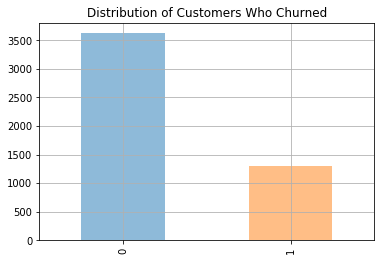

In [22]:
train_df.churn.value_counts().sort_index().plot(kind = "bar",alpha = .5)
plt.title("Distribution of Customers Who Churned")
plt.grid(b = True , which = "major")
plt.show()

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


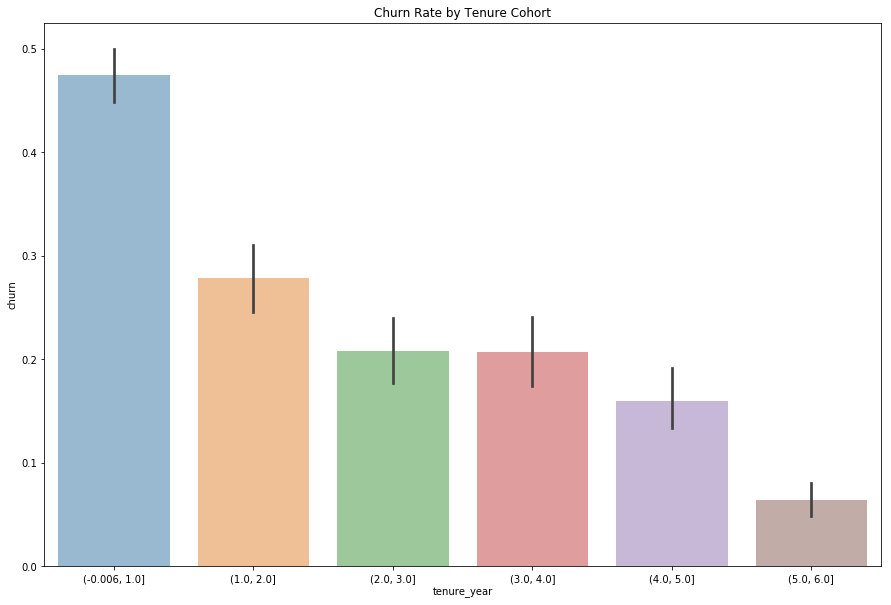

In [23]:
plt.figure(figsize=(15,10))
df_de1 = y_train
df_de1 = pd.concat([df_de1, pd.cut(X_train["tenure_year"], 6)], axis=1)
sns.barplot(x=df_de1.tenure_year, y=df_de1.churn, alpha=0.5)
plt.title("Churn Rate by Tenure Cohort")
plt.show()

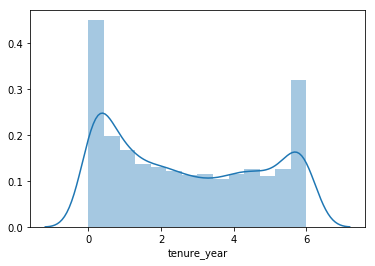

In [24]:
sns.distplot(train_df.tenure_year)

**1. Could the month in which customers signed up influence churn?**

- Churn is highest for customers with a tenure_year of less than or equal to 1, followed by those with a tenure_year greater than 1 but less than or equal to 2. There is a group of customers nearing tenure_year 6 with a fairly high churn rate.

**2. Are there features that indicate a higher propensity to churn?**

_Services/traits/demographic that indicate a higher propensity for churning:_

- Fiber optic customers have the highest churn rate, followed by DSL customers. Those with no internet have the lowest churn rate of the three groups
- Churn rate is pretty equal among phone_id. I think this mean that the type of phone service is not driving or connected with churn.
- Those without security or backup have the highest churn rate, followed by those with backup only.
- Seniors have a higher churn rate than non-seniors
- Those without device protection have a churn rate above the mean compared to those without
- Those with a "no" for tech_support have a churn rate above the mean compared to those with a "yes"
- Gender is not driving churn. No surprise here.
- Month-to-month contracts have a churn rate above the mean, and they churn much more than other contract types.
- Paperless billing have a churn rate above the mean
- E-check have a churn rate above the mean
- Those with no partner and no dependents have a churn rate above the mean; those with a partner and dependents have the lowest churn rate
- Those with streaming services have an above average churn rate

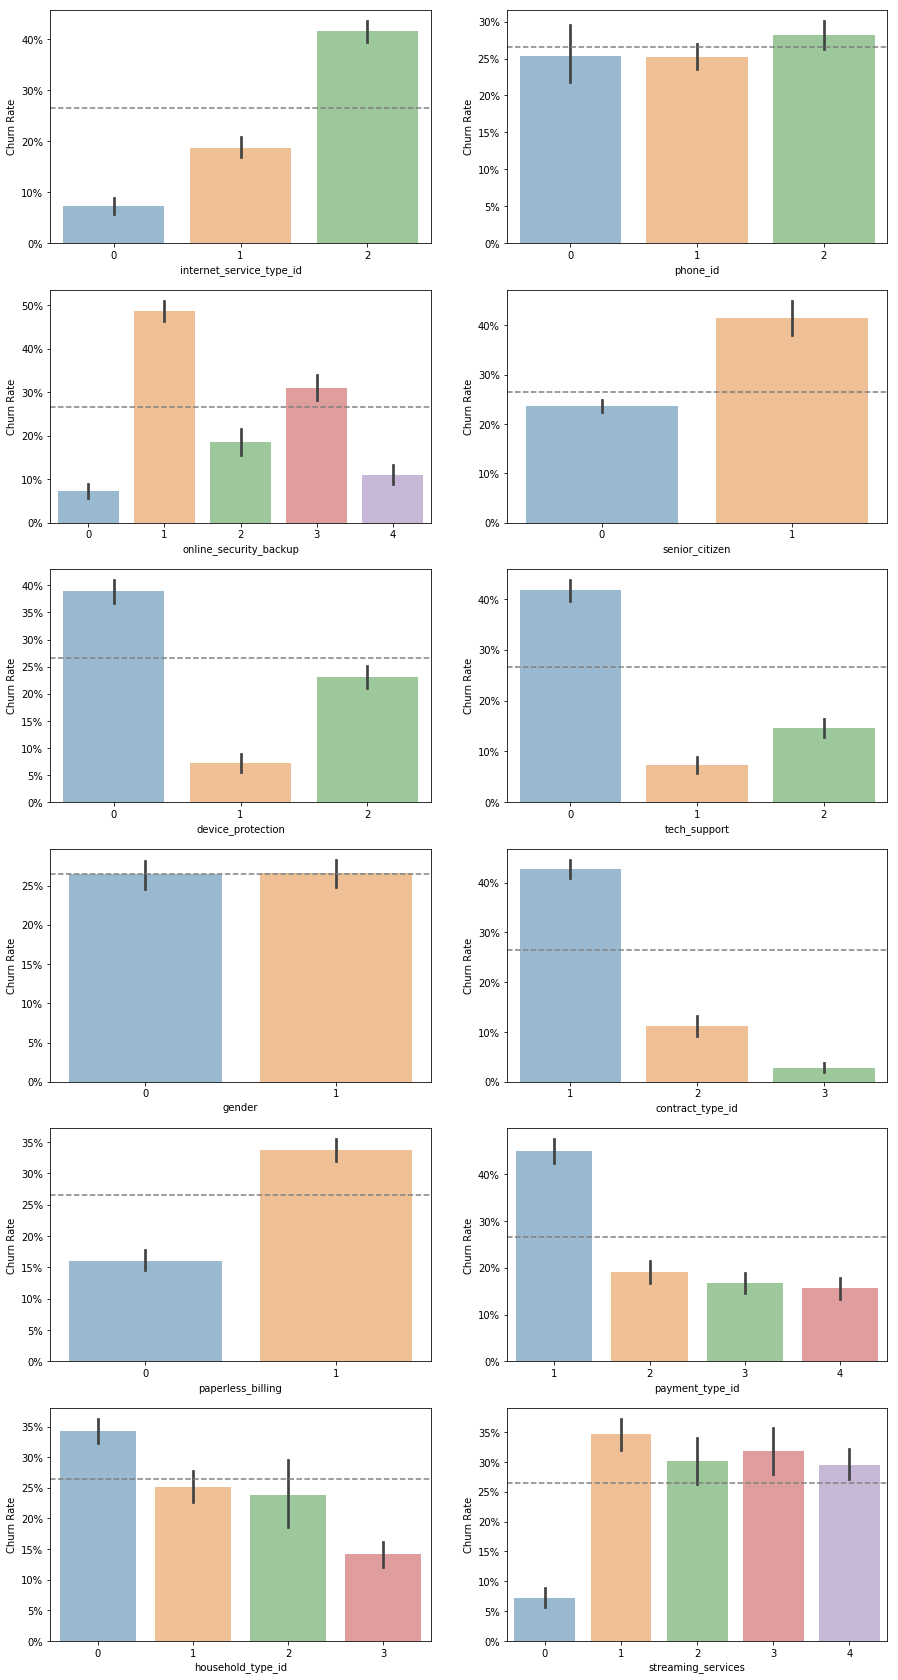

In [25]:
barplot_features = ['internet_service_type_id', 'phone_id', 'online_security_backup', 'senior_citizen', 'device_protection', 'tech_support',
           'gender', 'contract_type_id', 'paperless_billing', 'payment_type_id', 'household_type_id', 'streaming_services']
churn_rate = y_train.churn.mean()
plt.figure(figsize=(15, 30))
for i, feature in enumerate(barplot_features):
    plt.subplot(6, 2, i + 1)
    ax = sns.barplot(X_train[feature], y_train.churn, alpha=.5)
    ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
    plt.ylabel('Churn Rate')
    plt.axhline(churn_rate, ls='--', color='grey')
plt.show()

**3. Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point?**

- Internet
    - For no internet customers, there does not appear to be a price threshold that triggers churn
    - For DSL customers, it appears that a standardized threshold between 0.2 and 0.4 triggers some churn
    - For fiber customers, there does not appear to be a price threshold that triggers churn
- Phone
    - For no phone customers, customers paying a lower price have a more churn
    - For one line customers, churn increases after 0.5 standardized monthly price
    - For two+ line customers, churn increases after 0.6 standardized monthly price
- Online security & backup
    - There does not appear to be a price threshold that triggers churn for these customers
- Streaming services
    - Churn increases after 0.5 or 0.6 standardized price threshold for those with some kind of streaming service

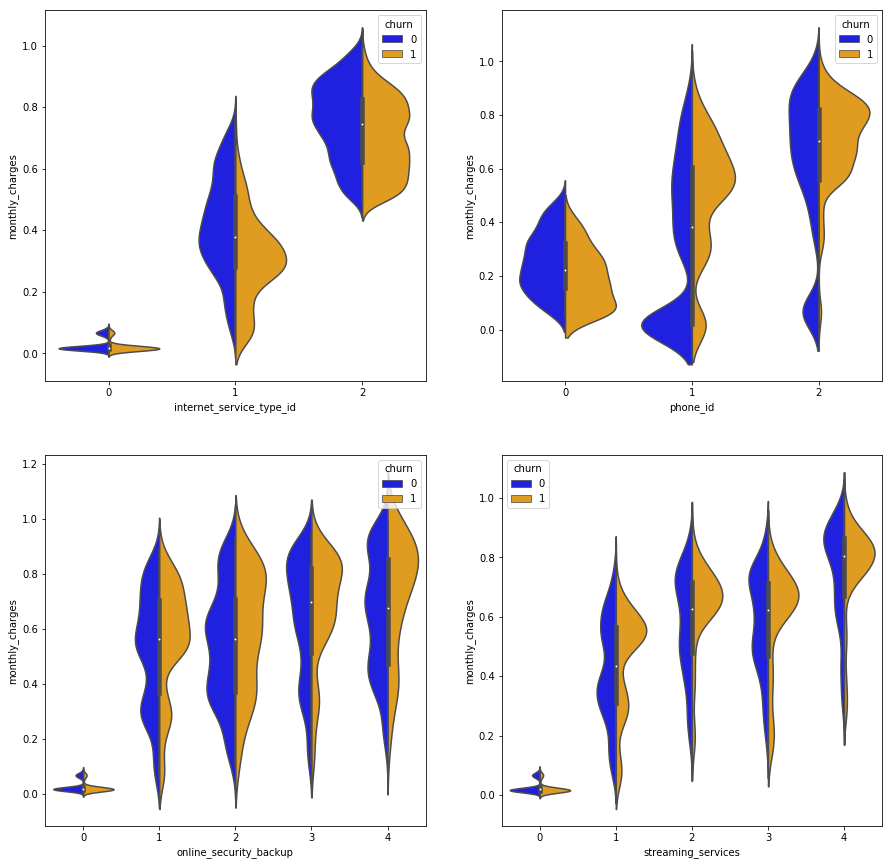

In [26]:
vplot_features = ['internet_service_type_id', 'phone_id', 'online_security_backup', 'streaming_services']

plt.figure(figsize=(15, 15))
for i, feature in enumerate(vplot_features):
    plt.subplot(2, 2, i + 1)
    sns.violinplot(feature, 'monthly_charges', hue='churn',
        data=train_df, split=True, palette=['blue','orange'])

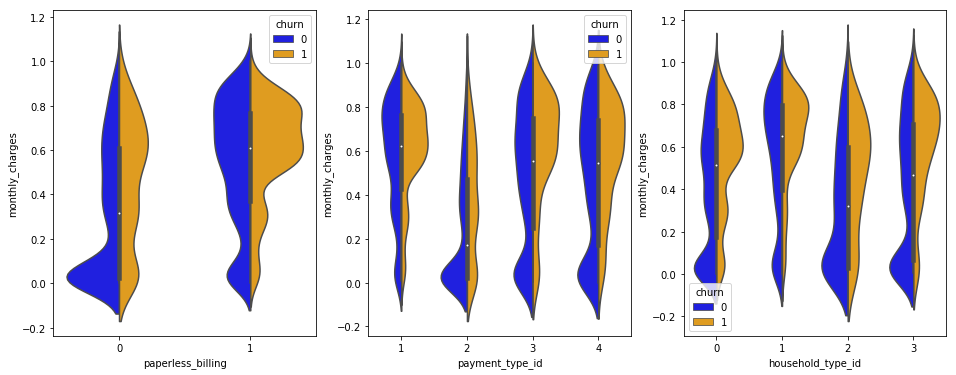

In [27]:
features = ['paperless_billing', 'payment_type_id', 'household_type_id']
feature_count = range(len(features))

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))

for i, feature in enumerate(features):
    sns.violinplot(feature, 'monthly_charges', hue='churn',
        data=train_df, split=True, ax=ax[i], palette=['blue','orange'])

**4. If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?**

- Those customers on a month-to-month have a higher churn rate even when excluding newer customers

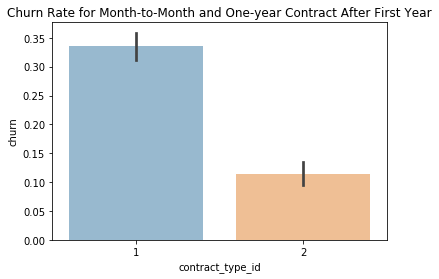

In [28]:
df_de4 = train_df[(train_df.tenure_year > 1) & ((train_df.contract_type_id == 1) | (train_df.contract_type_id == 2))][["contract_type_id", "churn"]]
sns.barplot(x=df_de4.contract_type_id, y=df_de4.churn, alpha=0.5)
plt.title("Churn Rate for Month-to-Month and One-year Contract After First Year")
plt.show()

**5. Controlling for services (phone_id, internet_service_type_id, online_security_backup, device_protection, tech_support, and contract_type_id), is the mean monthly_charges of those who have churned significantly different from that of those who have not churned?**

- When controlling for phone_id, internet_service_type_id, and contract_type_id, there is a significant difference in monthly_charges between those who churn and those who do not.

In [29]:
# df_value_counts(X_train)

col_dict = {"phone_id": [0, 1, 2], "internet_service_type_id": [0, 1, 2],
            "online_security_backup": [0, 1, 2, 3, 4],
            "device_protection": [0, 1, 2], "tech_support": [0, 1, 2], "contract_type_id": [1, 2, 3]}

for col, val in col_dict.items():
    for n in val:
        control = train_df[train_df[col] == n]
        group_not_churn = control[control.churn == 0]["monthly_charges"]
        group_churn = control[control.churn == 1]["monthly_charges"]
        print(f"Controlling for {col} with value {n}")
        print(stats.ttest_ind(group_not_churn.values, group_churn.values))
        print()
    print()

Controlling for phone_id with value 0
Ttest_indResult(statistic=5.169621075809402, pvalue=3.516794989022539e-07)

Controlling for phone_id with value 1
Ttest_indResult(statistic=-13.818842760096256, pvalue=7.929826766196399e-42)

Controlling for phone_id with value 2
Ttest_indResult(statistic=-7.862246991997568, pvalue=5.974955918845283e-15)


Controlling for internet_service_type_id with value 0
Ttest_indResult(statistic=2.4561882157002826, pvalue=0.014201339809922237)

Controlling for internet_service_type_id with value 1
Ttest_indResult(statistic=11.561176006600341, pvalue=8.874803666092163e-30)

Controlling for internet_service_type_id with value 2
Ttest_indResult(statistic=11.46086283978026, pvalue=1.385512730545397e-29)


Controlling for online_security_backup with value 0
Ttest_indResult(statistic=2.4561882157002826, pvalue=0.014201339809922237)

Controlling for online_security_backup with value 1
Ttest_indResult(statistic=-3.861833359960374, pvalue=0.00011723843710992576)

Cont

**6. How much of monthly_charges can be explained by internet_service_type?**

- I would hypothesize that there is a significant correlation between internet_service_type_id and monthly_charges. Those without internet service will have a lower average monthly_charge, followed by those with DSL, and then those with fiber. There is what appears to be a perfect positive correlation between the two variables, with a p-value of less than 0.05, indicating significance.

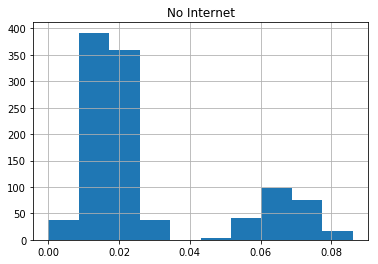

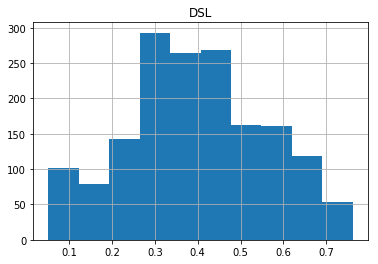

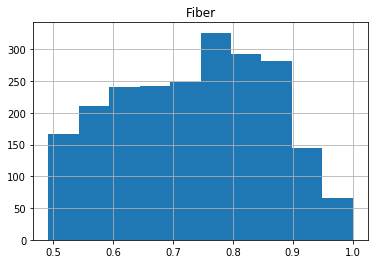

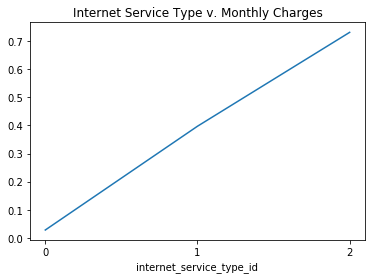

Pearson's R
internet_type:
	Pearson's R is 1.000 with a significance p-value of 0.018



In [30]:
# group with no internet
df_no_internet = X_train[X_train.internet_service_type_id == 0]["monthly_charges"]
df_no_internet.hist()
plt.title("No Internet")
plt.show()

# group with DSL
df_dsl = X_train[X_train.internet_service_type_id == 1]["monthly_charges"]
df_dsl.hist()
plt.title("DSL")
plt.show()

# group with fiber
df_fiber = X_train[X_train.internet_service_type_id == 2]["monthly_charges"]
df_fiber.hist()
plt.title("Fiber")
plt.show()

X_train.groupby("internet_service_type_id")["monthly_charges"].mean().plot()
plt.xticks([0, 1, 2])
plt.title("Internet Service Type v. Monthly Charges")
plt.show()

df_internet = pd.DataFrame({"internet_type": [0, 1, 2], "mean_monthly_charge": X_train.groupby("internet_service_type_id")["monthly_charges"].mean().values})
adalib.df_print_r_and_p_values(df_internet[["internet_type"]], df_internet.mean_monthly_charge)

**7. How much of monthly_charges can be explained by internet_service_type + phone service type (0, 1, or multiple lines).**

**8. Create visualizations exploring the interactions of variables** (independent with independent and independent with dependent). The goal is to **identify features that are related to churn**

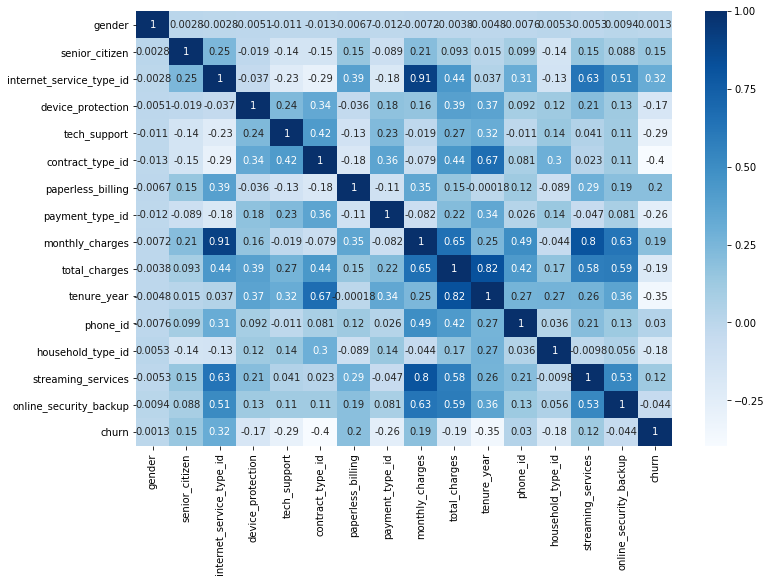

In [31]:
plt.figure(figsize=(12,8))
sns.heatmap(train_df.corr(), cmap='Blues', annot=True)

## Modeling

### Feature Selection
- Yes
    1. internet_service_type
    2. contract_type_id
- No
    1. gender
    2. phone_id (does nothing to logistic regression TP rate)
    3. senior_citizen (does nothing to logistic regression TP rate)
    4. tenure_year (drives down logistic regression true_positive by a lot)
    5. monthly_charges (drives down logistic regression true_positive)
    6. online_security_backup (drives down logistic_regression true_positive)
    7. tech_support
    8. device_protection (does nothing to logistic regression model TP rate)
    9. total_charges (drives down logistic regression model TP rate)
    10. payment_type_id (drives down logistic regression model TP rate)

### Modeling and Testing

#### Logistic Regression Model

In [32]:
def logreg_model1(features):
    preds_train, preds_test, model = adalib.logreg_fit_and_predict(X_train[features], y_train, X_test[features], y_test, class_weight="balanced", random_state=123)
    print("TRAIN EVALUATION")
    adalib.logreg_evaluate_model(y_train, preds_train)
    
    print("TEST EVALUATION")
    adalib.logreg_evaluate_model(y_test, preds_test)
    
    return preds_train, preds_test
    
# logreg_model1(X_train.columns)  # best model so far
logreg_model1(["internet_service_type_id", "contract_type_id"])

TRAIN EVALUATION
Accuracy: 0.7008113590263692

Confusion matrix:
          Pred -  Pred +
Actual -    2364    1258
Actual +     217    1091

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.65      0.76      3622
           1       0.46      0.83      0.60      1308

   micro avg       0.70      0.70      0.70      4930
   macro avg       0.69      0.74      0.68      4930
weighted avg       0.80      0.70      0.72      4930


Rates:
True positive rate: 0.8340978593272171
False positive rate: 0.5355470412941677
True negative rate: 0.6526780784097184
False negative rate: 0.08407593955831073

TEST EVALUATION
Accuracy: 0.7004259346900142

Confusion matrix:
          Pred -  Pred +
Actual -    1015     537
Actual +      96     465

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.65      0.76      1552
           1       0.46      0.83      0.60       561

   micro avg  

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(array([0, 0, 0, ..., 0, 0, 1]), array([1, 1, 0, ..., 0, 1, 0]))

#### Decision Tree Model

This is the best model we have created. It has one of the highest true positive rates (i.e., accurately predicts churn for those who do churn) and is also one of the simplest models. The downside is that it has a fairly high false positive rate, meaning we are a little worse than a flip of a coin at predicting churn for those who do not actually churn. This could lead to wasted resources if we target these individuals to prevent churn.

In [33]:
def dectree_model1(features):
    preds_train, preds_test, classes, model = adalib.dectree_fit_and_predict(X_train[features], y_train, X_test[features], y_test, class_weight="balanced", random_state=123)
    print("TRAIN EVALUATION")
    adalib.dectree_evaluate_model(y_train, preds_train, classes)
    
    print("TEST EVALUATION")
    adalib.dectree_evaluate_model(y_test, preds_test, classes)
    
    return preds_train, preds_test, model
    
preds_train, preds_test, tree_model = dectree_model1(["internet_service_type_id", "contract_type_id"])
preds_probs_train = tree_model.predict_proba(X_train[["internet_service_type_id", "contract_type_id"]])
preds_probs_test = tree_model.predict_proba(X_test[["internet_service_type_id", "contract_type_id"]])

TRAIN EVALUATION
Accuracy: 0.7008113590263692

Confusion matrix:
          Pred 0  Pred 1
Actual 0    2364    1258
Actual 1     217    1091

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.65      0.76      3622
           1       0.46      0.83      0.60      1308

   micro avg       0.70      0.70      0.70      4930
   macro avg       0.69      0.74      0.68      4930
weighted avg       0.80      0.70      0.72      4930


True 0 rate:  0.653
False 0 rate:  0.084

True 1 rate:  0.834
False 1 rate:  0.536

TEST EVALUATION
Accuracy: 0.7004259346900142

Confusion matrix:
          Pred 0  Pred 1
Actual 0    1015     537
Actual 1      96     465

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.65      0.76      1552
           1       0.46      0.83      0.60       561

   micro avg       0.70      0.70      0.70      2113
   macro avg       0.69      0.74      0.68

##### Visualize Decision Tree Model

In [34]:
import graphviz
from sklearn.tree import export_graphviz

feature_names = ["internet_service_type_id", "contract_type_id"]
class_names = ["not churn", "churn"]

dot = export_graphviz(
    tree_model,
    out_file=None,
    feature_names=feature_names,
    class_names=class_names, # target value names
    special_characters=True,
    filled=True,             # fill nodes w/ informative colors
    impurity=False,          # show impurity at each node
    leaves_parallel=True,    # all leaves at the bottom
    proportion=True,         # show percentages instead of numbers at each leaf
    rotate=True,             # left to right instead of top-bottom
    rounded=True,            # rounded boxes and sans-serif font
)

graph = graphviz.Source(dot, filename='churn_decision_tree', format='png')
graph.view(cleanup=True)

'churn_decision_tree.png'

### Output predictions to CSV

In [35]:
# combine preds_train and preds_test
preds_col = np.append(preds_train, preds_test, axis=0)

# combine preds_probs_train and preds_probs_test
preds_probs_col = np.append(preds_probs_train[:, 1], preds_probs_test[:, 1])

# combine customer_id in X_train and X_test
cid_col = pd.concat([X_train[["customer_id"]], X_test[["customer_id"]]], axis=0)

In [36]:
df_csv = pd.DataFrame({"customer_id": cid_col.customer_id, "prob_churn": preds_probs_col.round(2),
                       "pred_churn": preds_col})
df_csv.sort_values("customer_id", inplace=True)

In [37]:
df_csv.to_csv("churn_predictions.csv", index=False)

#### KNN Model

In [38]:
def knn_model1(train, test, features):
    pred_train, pred_test, classes, model = adalib.knn_fit_and_predict(
    train[features], train.churn, test[features], test.churn,
    n_neighbors=10, weights="distance"
    )

    print("TRAIN EVALUATION")
    adalib.knn_evaluate_model(train.churn, pred_train, classes)

    print("TEST EVALUATION")
    adalib.knn_evaluate_model(test.churn, pred_test, classes)
    
    return preds_train, preds_test, model

knn_model1(train_df, test_df, ["internet_service_type_id", "contract_type_id", "monthly_charges", "payment_type_id"])

TRAIN EVALUATION
Accuracy: 0.927789046653144

Confusion matrix:
          Pred 0  Pred 1
Actual 0    3550      72
Actual 1     284    1024

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      3622
           1       0.93      0.78      0.85      1308

   micro avg       0.93      0.93      0.93      4930
   macro avg       0.93      0.88      0.90      4930
weighted avg       0.93      0.93      0.93      4930


True 0 rate:  0.980
False 0 rate:  0.074

True 1 rate:  0.783
False 1 rate:  0.066

TEST EVALUATION
Accuracy: 0.7349739706578324

Confusion matrix:
          Pred 0  Pred 1
Actual 0    1339     213
Actual 1     347     214

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.83      1552
           1       0.50      0.38      0.43       561

   micro avg       0.73      0.73      0.73      2113
   macro avg       0.65      0.62      0.63 

(array([0, 0, 0, ..., 0, 0, 1]),
 array([1, 1, 0, ..., 0, 1, 0]),
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=None, n_neighbors=10, p=2,
            weights='distance'))

## Try to split along internet groups (non-fiber, fiber)

In [39]:
train_non_fiber = train_df[train_df.internet_service_type_id <= 1]
train_fiber = train_df[train_df.internet_service_type_id > 1]

test_non_fiber = test_df[test_df.internet_service_type_id <= 1]
test_fiber = test_df[test_df.internet_service_type_id > 1]

In [40]:
def dectree_model_internet_split(train, test, features):
    preds_train, preds_test, classes, model = adalib.dectree_fit_and_predict(train[features], train["churn"], test[features], test["churn"], class_weight="balanced", random_state=123)
    print("TRAIN EVALUATION")
    adalib.dectree_evaluate_model(train["churn"], preds_train, classes)
    
    print("TEST EVALUATION")
    adalib.dectree_evaluate_model(test["churn"], preds_test, classes)
    
    return preds_train, preds_test, model

def logreg_model_internet_split(train, test, features):
    preds_train, preds_test, classes, model = adalib.dectree_fit_and_predict(train[features], train["churn"], test[features], test["churn"], class_weight="balanced", random_state=123)
    print("TRAIN EVALUATION")
    adalib.dectree_evaluate_model(train["churn"], preds_train, classes)
    
    print("TEST EVALUATION")
    adalib.dectree_evaluate_model(test["churn"], preds_test, classes)
    
    return preds_train, preds_test, model

def knn_model_internet_split(train, test, features):
    pred_train, pred_test, classes, model = adalib.knn_fit_and_predict(
    train[features], train.churn, test[features], test.churn,
    n_neighbors=20, weights="distance"
    )

    print("TRAIN EVALUATION")
    adalib.knn_evaluate_model(train.churn, pred_train, classes)

    print("TEST EVALUATION")
    adalib.knn_evaluate_model(test.churn, pred_test, classes)
    
    return preds_train, preds_test, model

In [41]:
dectree_model_internet_split(train_non_fiber, test_non_fiber, ["contract_type_id", "tenure_year", "phone_id"])

TRAIN EVALUATION
Accuracy: 0.7681801402731635

Confusion matrix:
          Pred 0  Pred 1
Actual 0    1723     601
Actual 1      27     358

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.74      0.85      2324
           1       0.37      0.93      0.53       385

   micro avg       0.77      0.77      0.77      2709
   macro avg       0.68      0.84      0.69      2709
weighted avg       0.90      0.77      0.80      2709


True 0 rate:  0.741
False 0 rate:  0.015

True 1 rate:  0.930
False 1 rate:  0.627

TEST EVALUATION
Accuracy: 0.7092084006462036

Confusion matrix:
          Pred 0  Pred 1
Actual 0     745     306
Actual 1      54     133

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.71      0.81      1051
           1       0.30      0.71      0.42       187

   micro avg       0.71      0.71      0.71      1238
   macro avg       0.62      0.71      0.62

(array([0, 0, 0, ..., 0, 0, 0]),
 array([1, 0, 0, ..., 0, 1, 0]),
 DecisionTreeClassifier(class_weight='balanced', criterion='gini',
             max_depth=None, max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=123,
             splitter='best'))

In [42]:
dectree_model_internet_split(train_fiber, test_fiber, ["contract_type_id", "tenure_year"])

TRAIN EVALUATION
Accuracy: 0.7176947321026564

Confusion matrix:
          Pred 0  Pred 1
Actual 0     857     441
Actual 1     186     737

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.66      0.73      1298
           1       0.63      0.80      0.70       923

   micro avg       0.72      0.72      0.72      2221
   macro avg       0.72      0.73      0.72      2221
weighted avg       0.74      0.72      0.72      2221


True 0 rate:  0.660
False 0 rate:  0.178

True 1 rate:  0.798
False 1 rate:  0.374

TEST EVALUATION
Accuracy: 0.6651428571428571

Confusion matrix:
          Pred 0  Pred 1
Actual 0     310     191
Actual 1     102     272

Classification report:
              precision    recall  f1-score   support

           0       0.75      0.62      0.68       501
           1       0.59      0.73      0.65       374

   micro avg       0.67      0.67      0.67       875
   macro avg       0.67      0.67      0.66

(array([0, 0, 1, ..., 0, 0, 1]),
 array([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
     